# 1. Parameters preparation

## 0.0. **python** package importation

This script use:
- `pandas` - data importation, manipulation.
- `seaborn` and `matplotlib` - plotting
- `numpy` - matrix calculation
- `jupyter notebook` - editing
- `black` - formatting
- `pyshp` - gis shape file

In [97]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shapefile

sns.set_theme(style="whitegrid", palette="pastel")

## 0.1. Self defined functions and modules
- adm1_name_reformat, change to
    - Uppercase()
    - Substitute space to underscore

In [98]:
## requires util functions
def adm1_name_reformat(df,
                       original_column_name: str = 'adm1',
                       new_column_name: str = 'adm1',
                       set_index: bool = True):
    """
    pd dataframe reformatter for the pandas dataframe
    :param set_index:
    :param df:
    :param original_column_name:
    :param new_column_name:
    :return: new pandas DataFrame
    """
    assert (type(original_column_name) is str)
    # 1. Rename the column name to new_column_name
    if type(df) is pd.DataFrame:
        df = df.rename(
            columns={
                original_column_name: new_column_name
            }
        )
        # 2. reformat district name
        ## to upper case
        df[new_column_name] = df[new_column_name].map(lambda x: x.upper())
        ## change space to _
        df[new_column_name] = df[new_column_name].map(lambda x: x.replace(' ', '_'))
        ## change - to _
        df[new_column_name] = df[new_column_name].map(lambda x: x.replace('-', '_'))

        # 3. set index to the new column name
        if set_index: df = df.set_index(new_column_name)
    elif type(df) is pd.Series:
        df = df.rename(new_column_name)
        # 2. reformat district name
        ## to upper case
        df.index = df.index.map(lambda x: x.upper())
        ## change space to _
        df.index = df.index.map(lambda x: x.replace(' ', '_'))
        ## change - to _
        df.index = df.index.map(lambda x: x.replace('-', '_'))

    return df

In [99]:
def missing_data_interpolate(df: pd.DataFrame,
                             neighbour: pd.DataFrame,
                             column: str,
                             round_n: int = 3
                             ):
    """
    :param neighbour:
    :param df: pandas dataframe to be processed, the dataframe should firstly be process with reformat function, and the index of df should be adm1 provinces
    :param column: the target column
    :param round_n: round of averaging, the larger number the smoother, but requires more computing power, default is 3
    :return: df: calculated dataframe with filled data
    """
    def get_adjacent(
            adm1: str,
            adjacent_list: pd.DataFrame,
            from_column: str = 'from',
            to_column: str = 'to'
    ):
        return adjacent_list[adjacent_list[from_column] == adm1][to_column]

    def interpolate(_df: pd.DataFrame,
                    targeted_adm1: str,
                    targeted_column: str,
                    adjacent_adm1: pd.Series):
        adjacent_adm1_row = _df.loc[adjacent_adm1.tolist(), :]
        interpolated = adjacent_adm1_row[targeted_column].mean()
        result_row = _df.loc[targeted_adm1, :]
        result_row[targeted_column] = interpolated
        return result_row

    # 1. notation 标记
    df['__missing'] = df[column].map(lambda x: math.isnan(x))
    # 2. get missing adm1 regions
    for i in range(round_n):
        df = df.apply(lambda row: interpolate(
                _df=df,
                targeted_adm1=row.name,
                targeted_column=column,
                adjacent_adm1=get_adjacent(
                    adm1=row.name,
                    adjacent_list=neighbour
                )
            ) if row['__missing'] else row,
              axis= 1
        )

    df.drop(columns=['__missing'])
    return df

In [100]:
# test those methods

## 1.1. Admin1 District
This benchmarking practices is targeting at the adm1 level of district in Ghana.

> TODO Data retrieved from xxx

Code names of adm1 level was used for an unified experiences in the whole practices.

In [101]:
gha_admin1 = pd.read_csv("../Data/GHA/ADM1/admin.csv")
gha_admin1 = gha_admin1[["Subdivision name", "3166-2 code"]]
gha_admin1 = gha_admin1.rename(columns={'3166-2 code': 'code',
                                        'Subdivision name': 'adm1'
                                        })
gha_admin1['adm1'] = gha_admin1['adm1'].map(lambda x: x.upper())
gha_admin1 = adm1_name_reformat(df=gha_admin1,
                                original_column_name='adm1')
gha_admin1

,code
adm1,
AHAFO,GH-AF
ASHANTI,GH-AH
BONO,GH-BO
BONO_EAST,GH-BE
CENTRAL,GH-CP
EASTERN,GH-EP
GREATER_ACCRA,GH-AA
NORTH_EAST,GH-NE
NORTHERN,GH-NP


In [102]:
# load adjacent
gha_adjacent_provinces = pd.read_excel('../Data/gha_adm_adjacent.xlsx', sheet_name='adm1_adjacent')
gha_adjacent_provinces = adm1_name_reformat(df=gha_adjacent_provinces,
                                            original_column_name='a',
                                            new_column_name='from',
                                            set_index=False)
gha_adjacent_provinces = adm1_name_reformat(df=gha_adjacent_provinces,
                                            original_column_name='b',
                                            new_column_name='to',
                                            set_index=False)

gha_adjacent_provinces

,from,to
0,UPPER_WEST,UPPER_EAST
1,UPPER_WEST,NORTH_EAST
2,UPPER_WEST,SAVANNAH
3,UPPER_EAST,NORTH_EAST
4,NORTH_EAST,NORTHERN
5,SAVANNAH,NORTHERN
6,SAVANNAH,BONO
7,SAVANNAH,BONO_EAST
8,NORTHERN,OTI
9,BONO,BONO_EAST


## 1.2. Demographic

### 1.2.1. Data loading
Data source: TODO
- Ghana.gov *PHC*

The data source contains data from 1960 - 2020, datapoint of 2020 was used in this script.

In [103]:
# read data and get adm1 level demographic data
gha_demographic_raw_data = pd.read_excel("../Data/GHA/demographic/ghana.xlsx", "Sheet2")
gha_demographic_adm1_raw_data = gha_demographic_raw_data.loc[
    gha_demographic_raw_data["ADM_LEVEL"] == 1
    ]
gha_demographic_adm1_raw_data = gha_demographic_adm1_raw_data.set_index(
    keys="ADM1_NAME"
)
# select the most recent 2020 data
gha_demographic_adm1_raw_data_2020 = gha_demographic_adm1_raw_data.loc[
                                     :, "B0004_2020":"B80PL_2020"
                                     ]

gha_demographic_adm1_raw_data_2020

,B0004_2020,B0509_2020,B1014_2020,B1519_2020,B2024_2020,B2529_2020,B3034_2020,B3539_2020,B4044_2020,B4549_2020,B5054_2020,B5559_2020,B6064_2020,B6569_2020,B7074_2020,B7579_2020,B80PL_2020
ADM1_NAME,,,,,,,,,,,,,,,,,
GREATER ACCRA,562792,471879,439998,429804,491441,478293,432206,363844,281277,228398,180238,151122,98363,77530,39338,26523,23045
CENTRAL,389259,346383,324255,283276,229192,192138,174495,164120,136396,121988,108564,87339,66473,54200,34714,22242,22359
WESTERN,358543,326412,298320,259134,233689,201521,181249,169749,138897,118760,97724,75482,54027,41383,26135,16106,14727
EASTERN,391788,354485,335550,283848,220079,191968,178247,173134,151531,141148,124865,102543,76459,59505,42841,28580,24632
ASHANTI,793104,725015,695587,621325,568815,493449,445722,397291,321775,268951,223502,177509,121996,94402,67765,42511,37667
VOLTA,331306,293688,265366,231652,182550,154738,146049,136622,121843,114160,100552,82378,66867,53138,39546,27766,23895
BRONG-AHAFO,366787,345518,313807,265250,217111,185600,169053,154302,127935,109462,93110,71105,52250,38138,30987,22039,18176
NORTHERN,554924,510494,367770,317915,246875,218362,203873,168327,145225,109935,97423,59594,70970,44940,37992,21649,24962
UPPER WEST,139272,143051,124619,111408,97597,70318,64405,56198,48191,40393,35629,27644,28005,20217,14884,11401,9723


### 1.2.2. Get **Median Age** for adm1 district

1. Calculate total population
2. Calculate median population number
3. `.expanding` columns with `.cumsum` to get the according column
4. subtract group label using `.bfill`, `.iloc` & `.idmax`
5. get median age with `df.apply` with `lambda` function

In [104]:
gha_demographic_adm1_2020_population_total = gha_demographic_adm1_raw_data_2020.sum(
    axis=1
)
gha_demographic_adm1_2020_population_median = (
        gha_demographic_adm1_2020_population_total / 2
)
# expand columns, each column = to cumsum the previous columns
gha_demographic_adm1_2020_population_expanding = (
    gha_demographic_adm1_raw_data_2020.expanding(axis=1).sum()
)
# expanded columns - median, the first non negative column is where median
gha_demographic_adm1_2020_raw_subtract_median = (
    gha_demographic_adm1_2020_population_expanding.subtract(
        gha_demographic_adm1_2020_population_median, axis=0
    )
)
# get ratio in groups
# check the answer here
# https://stackoverflow.com/questions/38467749/find-first-non-zero-value-in-each-row-of-pandas-dataframe/38468180
gha_demographic_adm1_2020_median_ratio = (
        gha_demographic_adm1_2020_raw_subtract_median.where(
            gha_demographic_adm1_2020_raw_subtract_median > 0
        )
        / gha_demographic_adm1_raw_data_2020
)
gha_demographic_adm1_2020_median_ratio = (
        gha_demographic_adm1_2020_median_ratio.bfill(1).iloc[:, 0] * 4
)
# get group labels
gha_demographic_adm1_2020_median_group_value = (
        gha_demographic_adm1_raw_data_2020 - gha_demographic_adm1_2020_population_expanding
)
gha_demographic_adm1_median_group_labels = (
        gha_demographic_adm1_2020_raw_subtract_median > 0
).idxmax(axis=1)
# get first two string as the start of age group
gha_demographic_adm1_median_group_labels = (
    gha_demographic_adm1_median_group_labels.apply(lambda x: float(x[1:3]))
)
# add age group with ratio
gha_demographic_adm1_2020_median = (
        gha_demographic_adm1_median_group_labels + gha_demographic_adm1_2020_median_ratio
)

gha_demographic_adm1_2020_median

gha_demographic_adm1_2020_phc = pd.read_excel(
    '../Data/GHA/Demographic/2021_PHC/2021 PHC summary.xlsx'
)
gha_demographic_adm1_2020_mean = gha_demographic_adm1_2020_phc[['region', 'mean_age']]
gha_demographic_adm1_2020_mean = adm1_name_reformat(df=gha_demographic_adm1_2020_mean,
                                                    original_column_name='region')
gha_demographic_adm1_2020_mean

/var/folders/jw/1fjpkkvx6wz8tmmfqfklf4b80000gn/T/ipykernel_6260/1444544103.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.bfill will be keyword-only
  gha_demographic_adm1_2020_median_ratio.bfill(1).iloc[:, 0] * 4


,mean_age
adm1,
WESTERN,25.0
CENTRAL,25.6
GREATER_ACCRA,26.8
VOLTA,27.3
EASTERN,26.8
ASHANTI,25.2
WESTERN_NORTH,24.4
AHAFO,25.0
BONO,25.6


### 1.2.4. Adm2 level population
Data source: GHA/incid from WHO/GMP

In [105]:
incid = pd.read_csv('../Data/GHA/Routine_data/District-level/incid.csv')
incid = incid[incid['year'] == 2018]
incid = adm1_name_reformat(
    df=incid,
    original_column_name='adm1',
    set_index=False
)
incid.sample(5)
gha_adm2_population = incid[['adm1', 'adm2', 'pop']]
gha_adm2_population = gha_adm2_population.rename(columns={
    'pop': 'population'
})
gha_adm2_population.sample(5)

,adm1,adm2,population
832,UPPER_WEST,DAFFIAMA BUSSIE ISSA,38894.0
62,ASHANTI,EJURA-SEKYEDUMASE,102291.0
196,BONO,SUNYANI WEST,103308.0
872,UPPER_WEST,NADOWLI-KALEO,72829.0
519,GREATER_ACCRA,AYAWASO NORTH MUNICIPAL,267422.0


### 1.2.4. Create `pandas` dataframe from the retrieved index and columns

In [106]:
columns = [
    "eta",
    "rho",
    "a0",
    "sigma2",
    "max_age",
    "rA",
    "rT",
    "rD",
    "rU",
    "rP",
    "dE",
    "delayGam",
    "cD",
    "cT",
    "cU",
    "gamma1",
    "d1",
    "dID",
    "ID0",
    "kD",
    "uD",
    "aD",
    "fD0",
    "gammaD",
    "alphaA",
    "alphaU",
    "b0",
    "b1",
    "dB",
    "IB0",
    "kB",
    "uB",
    "phi0",
    "phi1",
    "dCA",
    "IC0",
    "kC",
    "uCA",
    "PM",
    "dCM",
    "delayMos",
    "tau1",
    "tau2",
    "mu0",
    "Q0",
    "chi",
    "bites_Bed",
    "bites_Indoors",
    "muEL",
    "muLL",
    "muPL",
    "dEL",
    "dLL",
    "dPL",
    "gammaL",
    "km",
    "cm",
    "betaL",
    "num_int",
    "itn_cov",
    "irs_cov",
    "ITN_IRS_on",
    "DY",
    "d_ITN0",
    "r_ITN0",
    "r_ITN1",
    "r_IRS0",
    "d_IRS0",
    "irs_half_life",
    "itn_half_life",
    "IRS_interval",
    "ITN_interval",
]

gha = pd.DataFrame(columns=columns,
                   index=gha_demographic_adm1_2020_mean.index)

### 1.2.4. ETA
Death rates for exponential population distribution,

$$ ETA = \frac{1}{MeanAge}$$

Default ETA = 0.0001305

In [107]:
gha["eta"] = 1 / (gha_demographic_adm1_2020_mean * 365)
gha['eta']

adm1
WESTERN          0.000110
CENTRAL          0.000107
GREATER_ACCRA    0.000102
VOLTA            0.000100
EASTERN          0.000102
ASHANTI          0.000109
WESTERN_NORTH    0.000112
AHAFO            0.000110
BONO             0.000107
BONO_EAST        0.000116
OTI              0.000115
NORTHERN         0.000152
SAVANNAH         0.000126
NORTH_EAST       0.000129
UPPER_EAST       0.000109
UPPER_WEST       0.000112
Name: eta, dtype: float64


@param eta Death rates for exponential population distribution, i.e. 1/Mean Population Age. Default = 0.0001305

@param rho Age-dependent biting parameter. Default = 0.85

@param a0 Age-dependent biting parameter. Default = 2920

@param sigma2 Variance of the log heterogeneity in biting rates. Default = 1.67

@param max_age Maximum age in days. Default = 100*365

@param rA Rate of leaving asymptomatic infection. Default = 0.00512821

@param rT Rate of leaving treatment. Default = 0.2

@param rD Rate of leaving clinical disease. Default = 0.2

@param rU Rate of recovering from subpatent infection. Default = 0.00906627

@param rP Rate of leaving prophylaxis. Default = 0.06666667

@param dE Latent period of human infection. Default = 12

@param delayGam Lag from parasites to infectious gametocytes. Default = 12.5

@param cD Untreated disease contribution to infectiousness. Default = 0.0676909

@param cT Treated disease contribution to infectiousness. Default =   0.322 * cD

@param cU Subpatent disease contribution to infectiousness. Default = 0.006203

@param gamma1 Parameter for infectiousness of state A. Default = 1.82425

@param d1 Minimum probability due to maximum immunity. Default = 0.160527

@param dID Inverse of decay rate. Default = 3650

@param ID0 Scale parameter. Default = 1.577533

@param kD Shape parameter. Default = 0.476614

@param uD Duration in which immunity is not boosted. Default = 9.44512

@param aD Scale parameter relating age to immunity. Default = 8001.99

@param fD0 Time-scale at which immunity changes with age. Default = 0.007055

@param gammaD Shape parameter relating age to immunity. Default = 4.8183

@param alphaA PCR detection probability parameters state A. Default = 0.757

@param alphaU PCR detection probability parameters state U. Default = 0.186

@param b0 Maximum probability due to no immunity. Default = 0.590076

@param b1 Maximum relative reduction due to immunity. Default = 0.5

@param dB Inverse of decay rate. Default = 3650

@param IB0 Scale parameter. Default = 43.8787

@param kB Shape parameter. Default = 2.15506

@param uB Duration in which immunity is not boosted. Default = 7.19919

@param phi0 Maximum probability due to no immunity. Default = 0.791666

@param phi1 Maximum relative reduction due to immunity. Default = 0.000737

@param dCA Inverse of decay rate. Default = 10950

@param IC0 Scale parameter. Default = 18.02366

@param kC Shape parameter. Default = 2.36949

@param uCA Duration in which immunity is not boosted. Default = 6.06349

@param PM New-born immunity relative to mother’s. Default = 0.774368

@param dCM Inverse of decay rate of maternal immunity. Default = 67.6952

@param delayMos Extrinsic incubation period. Default = 10

@param tau1 Duration of host seeking, assumed to be constant between species. Default = 0.69

@param tau2 Duration of mosquito resting after feed. Default = 2.31

@param mu0 Daily mortality of adult mosquitos. Default = 0.132

@param Q0 Anthrophagy probability. Default = 0.92

@param chi Endophily probability. Default = 0.86

@param bites_Bed Percentage of bites indoors and in bed. Default = 0.89

@param bites_Indoors Percentage of bites indoors . Default = 0.97

@param muEL Per capita daily mortality rate of early stage larvae (low density). Default = 0.0338

@param muLL Per capita daily mortality rate of late stage larvae (low density). Default = 0.0348

@param muPL Per capita daily mortality rate of pupae. Default = 0.249

@param dEL Development time of early stage larvae. Default = 6.64

@param dLL Development time of late stage larvae. Default = 3.72

@param dPL Development time of pupae. Default = 0.643

@param gammaL Relative effect of density dependence on late instars relative to early instars. Default = 13.25

@param km Seasonal carrying capacity. Default = 11

@param cm Seasonal birth rate. Default = 0.05

@param betaL Number of eggs laid per day per mosquito. Default = 21.2

@param num_int Number of intervention parameters.  Default = 4

@param itn_cov The proportion of people that use an ITN. Default = 0

@param irs_cov The proportion of people living in houses that have been sprayed. Default = 0

@param ITN_IRS_on Time of ITN and IRS to be activated. Default = -1, i.e. never.

@param DY Duration of year (days). Default = 365

@param d_ITN0 Probability of dying with an encounter with ITN (max). Default = 0.41

@param r_ITN0 Probability of repeating behaviour with ITN (max). Default = 0.56

@param r_ITN1 Probability of repeating behaviour with ITN (min). Default = 0.24

@param r_IRS0 Probability of repeating behaviour with IRS (min). Default = 0.6

@param d_IRS0 Probability of dying with an encounter with IRS (max). Default = 1

@param irs_half_life IRS half life. Default =   0.5 * DY

@param itn_half_life ITN half life. Default =   2.64 * DY

@param IRS_interval How long before IRS is repeated, i.e. when IRS decay = 1. Default =   1 * DY

@param ITN_interval How long before ITN is repeated, i.e. when IRS decay = 1.  Default =   3 * DY

In [108]:
### 1.2.5. rho

gha["rho"] = 0.85
gha["a0"] = 2920
gha["sigma2"] = 1.67
gha["max_age"] = 100 * 365
gha["rA"] = 0.00512821
gha["rT"] = 0.2
gha["rD"] = 0.2
gha["rU"] = 0.00906627
gha["rP"] = 0.06666667
# TODO check if this data is available from the data folder
gha["dE"] = 12
gha["delayGam"] = 12.5
gha["cD"] = 0.0676909
gha["cT"] = 0.322 * gha["cD"]
gha["cU"] = 0.006203
gha["gamma1"] = 1.82425
gha["d1"] = 0.160527
gha["dID"] = 3650
gha["ID0"] = 1.577533
gha["kD"] = 0.476614
gha["uD"] = 9.44512
gha["aD"] = 8001.99
gha["fD0"] = 0.007055
gha["gammaD"] = 4.8183
gha["alphaA"] = 0.757
gha["alphaU"] = 0.186
gha["b0"] = 0.590076
# Maximum relative reduction due to immunity
gha["b1"] = 0.5
# Immunity Inverse of decay rate
gha["dB"] = 3650
gha["IB0"] = 43.8787
gha["kB"] = 2.15506
gha["uB"] = 7.19919
gha["phi0"] = 0.791666
gha["phi1"] = 0.000737
gha["dCA"] = 10950
gha["IC0"] = 18.02366
gha["kC"] = 2.36949
gha["uCA"] = 6.06349
gha["PM"] = 0.774368
gha["dCM"] = 67.695
# TODO check this parameter, extrinsic incubation period
gha["delayMos"] = 10
# duration of host seeking, assumed to be constant between species
gha["tau1"] = 0.69
# duration of mosquito resting after feed
gha["tau2"] = 2.31
# daily mortality of adult mosquitos
# TODO
gha["mu0"] = 0.13
# Anthrophagy probability
# TODO
gha["Q0"] = 0.92
# TODO
# Endophily probability
gha["mu0"] = 0.86
# TODO
# Percentage of bites indoors and in bed
gha["bites_Bed"] = 0.89
# Percentage of bites indoors
gha["bites_Indoors"] = 0.97
# Per capita daily mortality rate of early stage larvae(low density)
gha["muEL"] = 0.0338
# Per capita daily mortality rate of late stage larvae(low density)
gha["muLL"] = 0.0348
# Per capita daily mortality rate of pupae
gha["muPL"] = 0.249
# Development time of early stage larvae
gha["dEL"] = 6.64
# Development time of late stage larvae
gha["dLL"] = 3.72
# Development time of pupae
gha["dPL"] = 0.643
# Relative effect of density dependence on late instars relative to early instars
gha["gammaL"] = 13.25
# TODO
# Seasonal carrying capacity
gha["km"] = 11
# TODO
# Seasonal birth rate
gha["cm"] = 0.05
# TODO
# N of eggs laid per day per mosquito
gha["betaL"] = 21.2
# TODO
# N of intervention parameters
gha["num_int"] = 4
# TODO
# The proportion of people that use an ITN
gha["itn_cov"] = 0
# TODO
# The proportion of people that living in houses that have been sprayed
gha["irs_cov"] = 0
# todo
# Time of ITN and IRS to be activated.
gha["ITN_IRS_on"] = -1
# Duration of years
gha["DY"] = 365
# Probability of dying with an encounter with ITN(max)
gha["d_ITN0"] = 0.41
# Probability of repeating behaviour with ITN(max)
gha["r_ITN0"] = 0.56
# Probability of repeating behaviour with ITN(min)
gha["r_ITN1"] = 0.24
# Probability of repeating behaviour with IRS(min)
gha["r_IRS0"] = 0.6
# Probability of dying with an encounter with IRS(max)
gha["d_IRS0"] = 1
# IRS half life
gha["irs_half_life"] = 0.5 * 365
# ITN half life
gha["itn_half_life"] = 2.64 * 365
# How long before IRS is repeated
gha["IRS_interval"] = 1 * 365
# how long before ITN is repeated
gha["ITN_interval"] = 3 * 365

3. a0

### 2. Interventions

TODO

In [109]:
GHA_Intervention_data = pd.read_excel(
    "../Data/GHA/Interventions/GHA_Intervention_data.xlsx", "Data template "
)
GHA_Intervention_data

,adm1,adm2,year,month,smc_yn,llins_yn,irs_yn,pbo_yn,smc1_num,smc2_num,smc3_num,smc4_num,llins_num,irs_cov,irs_popprot,irs_struct_target,irs_struct_spr
0,NaN,NaN,2008,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Northern,Gushegu,2008,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,89994,NaN,38874
2,Northern,Karaga,2008,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,75290,NaN,29114
3,Northern,Savelugu,2008,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,116579,NaN,44610
4,Northern,Tolon,2008,NaN,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,160043,NaN,68182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,Western North,Bodi,2018,NaN,0,1,0,0,NaN,NaN,NaN,NaN,54740.0,NaN,NaN,NaN,NaN
747,Western North,Juaboso,2018,NaN,0,1,0,0,NaN,NaN,NaN,NaN,96144.0,NaN,NaN,NaN,NaN
748,Western North,Sefwi Akontombra,2018,NaN,0,1,0,0,NaN,NaN,NaN,NaN,61735.0,NaN,NaN,NaN,NaN
749,Western North,Sefwi-Wiawso,2018,NaN,0,1,0,0,NaN,NaN,NaN,NaN,96608.0,NaN,NaN,NaN,NaN


In [110]:
pd.merge(
    gha_admin1,
    GHA_Intervention_data,
    left_on="adm1",
    right_on="adm1",
)

,adm1,code,adm2,year,month,smc_yn,llins_yn,irs_yn,pbo_yn,smc1_num,smc2_num,smc3_num,smc4_num,llins_num,irs_cov,irs_popprot,irs_struct_target,irs_struct_spr


### 3. EIR estimation

In [111]:
eir = pd.read_csv("../Data/eir.csv")
ghana_eir = eir[eir["Country"] == "Ghana"]

<AxesSubplot:xlabel='setting', ylabel='eir'>

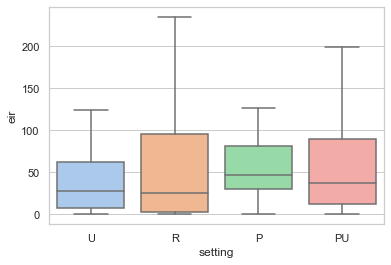

In [112]:
# TODO create a graph using eir data
sns.boxplot(data=eir, y='eir', x='setting', showfliers=False)

<AxesSubplot:xlabel='Year_Catagorical', ylabel='eir'>

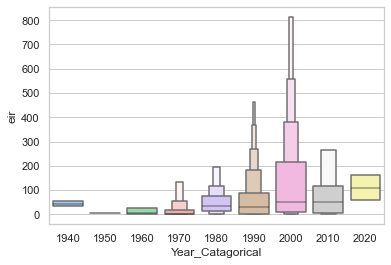

In [113]:
eir['Year_Catagorical'] = eir['Year'] // 10 * 10
sns.boxenplot(data=eir, y='eir', x='Year_Catagorical', showfliers=False)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'ashanti'),
  Text(1, 0, 'Bono'),
  Text(2, 0, 'Bono east'),
  Text(3, 0, 'Greater Accra'),
  Text(4, 0, 'Upper east')])

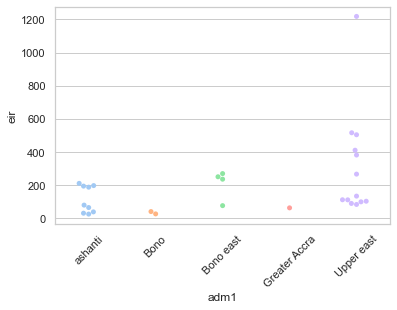

In [114]:
# plot ghana eir data
# TODO: To include 95%CI low and high data.
g = sns.swarmplot(data=ghana_eir, y='eir', x='adm1')
plt.xticks(rotation=45)

### EIR calculation

1. search through papers to find eir dataset
2. generate existing dataset
3. check availability for adm1
4. calculate eir for available adm1 region
5. estimate eir for unavailable adm1 region

<AxesSubplot:xlabel='adm1'>

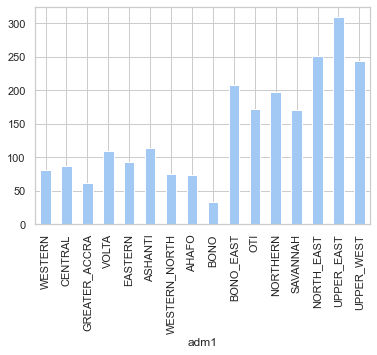

In [115]:
gha_eir = ghana_eir.groupby(by='adm1').mean()
gha_eir = gha_eir['eir']
gha_eir = adm1_name_reformat(gha_eir)
gha_eir
gha['eir'] = gha_eir

gha = missing_data_interpolate(df=gha,
                               neighbour=gha_adjacent_provinces,
                               column='eir',
                               round_n=10
                               )

gha['eir'].plot.bar()

### 4. Intervention

Data source - GHA_new_district_summaries - WHO/GMP

aggragation over

$$ITN_{adm1} =\frac{\sum{(P_{adm2}*ITN_{adm2})}}{P_{adm1}}$$


/Users/sepmein/.pyenv/versions/3.9.7/envs/sci2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/sepmein/.pyenv/versions/3.9.7/envs/sci2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='itn_cov'>

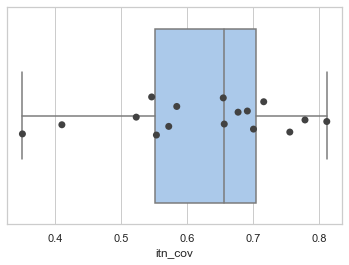

In [116]:
# gha_intervention = pd.read_stata('../Data/GHA/interventions/interventions.dta')
itn_coverage = pd.read_excel(io='/Users/sepmein/Dropbox/benchmarking/Data/GHA/MAP_District_Estimates/Maps_by_MAP_260districts/GHA_summaries/GHA_new_district_summaries.xlsx',
                             sheet_name='district_summaries')
itn_coverage = adm1_name_reformat(df=itn_coverage,
                                  original_column_name='REGION',
                                  set_index=False)

itn_coverage = itn_coverage.rename(columns={
    'DISTRICT': 'adm2'
})
itn_coverage = itn_coverage[['adm1', 'adm2', 'ITN_2018']]
itn_coverage = pd.merge(left=gha_adm2_population,
         right=itn_coverage,
         left_on='adm2',
         right_on='adm2')

itn_coverage = itn_coverage.drop(columns=['adm1_x'],axis=1)
itn_coverage = itn_coverage.rename(columns={
    'adm1_y': 'adm1'
})
itn_coverage['population_itn'] = itn_coverage['population'] * itn_coverage['ITN_2018']
itn_coverage_groupby_sum = itn_coverage.groupby(by='adm1').sum()
itn_coverage_groupby_sum['itn_coverage'] = itn_coverage_groupby_sum['population_itn']/itn_coverage_groupby_sum['population']
gha['itn_cov'] = itn_coverage_groupby_sum['itn_coverage']
sns.stripplot(gha['itn_cov'], size=7, color='.26')
sns.boxplot(gha['itn_cov'], showfliers=False)

### 5. Treatment seeking

Latest data - 2016

- **any_treat** - percentage of treatment from public sector **and** private sector
- **pub_treat** - data from **only** public sector

,adm1,any_treat,pub_treat
0,Western,0.582970,0.356210
1,Central,0.702795,0.294569
2,Greater Accra,0.757498,0.258062
3,Volta,0.789922,0.405711
4,Eastern,0.827497,0.417564
5,Ashanti,0.606210,0.193321
6,Brong Ahafo,0.757674,0.487024
7,Northern,0.849404,0.521830
8,Upper East,0.852665,0.581014
9,Upper West,0.639017,0.472995


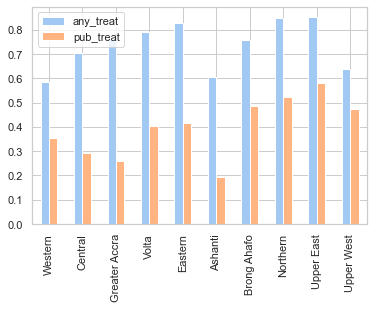

In [117]:
# 216 region
treatment_seeking_216 = pd.read_csv(
    '../Data/GHA/MAP_District_Estimates/Maps_byMAP_216districts/GHA_regional_DHS_treatment_seeking/GHA_TreatmentSeeking.csv')
treatment_seeking_216 = treatment_seeking_216.rename(columns={
    "REGNAME": "adm1"
})
treatment_seeking_216 = treatment_seeking_216[['adm1', 'any_treat', 'pub_treat']]

ax = treatment_seeking_216.plot(kind='bar')
##ax.set_xticks(treatment_seeking_216[['adm1']])
ax.set_xticklabels(treatment_seeking_216['adm1'])

##treatment_seeking_216[['adm1']]
treatment_seeking_216

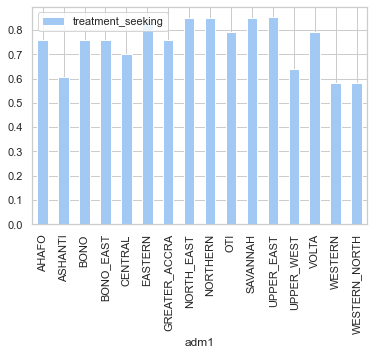

In [118]:
# 260 region

treatment_seeking_260 = pd.read_excel('../Data/GHA/MIS-DHS_data/GHA_treatment_seeking_tprs_adm1_16regions.xlsx',
                                      'Sheet')
treatment_seeking_260 = treatment_seeking_260[['adm1', 'pub_treat']]
treatment_seeking_260 = treatment_seeking_260.rename(columns={
    'pub_treat': 'treatment_seeking'
})

treatment_seeking_260 = adm1_name_reformat(df=treatment_seeking_260,
                                           original_column_name='adm1')
treatment_seeking_260

ax = treatment_seeking_260.plot(kind='bar')
##ax.set_xticks(treatment_seeking_216[['adm1']])


In [120]:
gha = pd.merge(
    left=gha,
    right=treatment_seeking_260[['adm1', 'treatment_seeking']],
    how='left',
    left_index=True,
    right_on='adm1')
gha['treatment_seeking']

KeyError: "['adm1'] not in index"

In [ ]:
# shapefile
gha_shape = shapefile.Reader(
    '../Data/GHA/WHO_Health_District_Shapefiles/Ghana _Shape_260 Districts_Boundary. 26.06.2019/260_Districts_of_Ghana')
shapes = gha_shape.shapes()

In [ ]:
# for shape in shapes:
#     for point in shape.points:
#         x,y = point
#         plt.plot(x,y)
# plt.show()

In [ ]:
gha_shape.records()


def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords'
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df


gha_shape_df = read_shapefile(gha_shape)
gha_shape_df.shape
gha_shape_df.sample(5)

In [ ]:
def plot_shape(id, s=None, sf=None):
    """ PLOTS A SINGLE SHAPE """
    plt.figure()
    ax = plt.axes()
    ax.set_aspect('equal')
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points), 1))
    y_lat = np.zeros((len(shape_ex.points), 1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    plt.plot(x_lon, y_lat)
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)
    plt.text(x0, y0, s, fontsize=10)
    # use bbox (bounding box) to set plot limits
    plt.xlim(shape_ex.bbox[0], shape_ex.bbox[2])
    return x0, y0


def plot_map(sf, x_lim=None, y_lim=None, figsize=(11, 9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize=figsize)
    id = 0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')

        #if (x_lim == None) & (y_lim == None):
        #    x0 = np.mean(x)
        #    y0 = np.mean(y)
        #    plt.text(x0, y0, id, fontsize=10)
        #id = id+1

    if (x_lim != None) & (y_lim != None):
        plt.xlim(x_lim)
        plt.ylim(y_lim)


plot_map(gha_shape, figsize=(10, 12))